In [1]:
# display the images
from PIL import Image
import matplotlib.pyplot as plt


In [2]:
%matplotlib inline

In [3]:


img_1_path = "kitchen/IMG20241128085234.jpg"
img_2_path = "kitchen/IMG20241128085236.jpg"
img_3_path = "kitchen/IMG20241128085238.jpg"

img_1 =  Image.open(img_1_path)
img_2 =  Image.open(img_2_path)
img_3 =  Image.open(img_3_path)

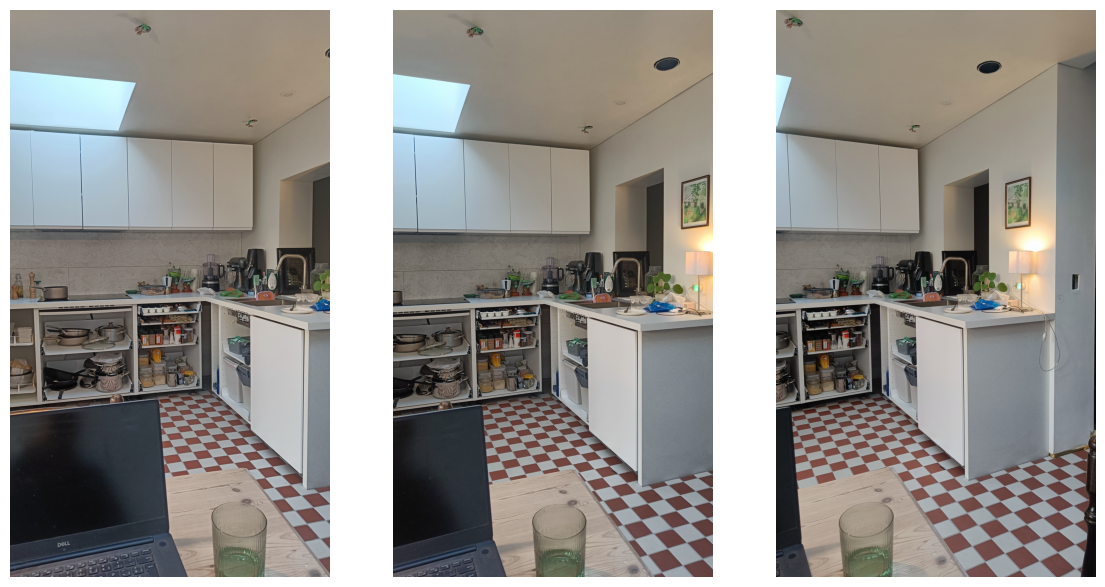

In [4]:

def display_images(imgs):
    fig = plt.figure(figsize=(14, 10))
    for i, img in enumerate(imgs):
        fig.add_subplot(1, len(imgs), i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

display_images([img_1, img_2, img_3])


In [5]:
# get SIFT and SURF features

import cv2
import numpy as np

def get_sift_features(img):
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create(5000)
    kp, des = sift.detectAndCompute(gray, None)
    return kp, des




kp_1_sift, des_1_sift = get_sift_features(img_1)
kp_2_sift, des_2_sift = get_sift_features(img_2)
kp_3_sift, des_3_sift = get_sift_features(img_3)


print(f"Number of SIFT features in image 1: {len(kp_1_sift)}")
print(f"Number of SIFT features in image 2: {len(kp_2_sift)}")
print(f"Number of SIFT features in image 3: {len(kp_3_sift)}")



Number of SIFT features in image 1: 5000
Number of SIFT features in image 2: 5000
Number of SIFT features in image 3: 5000


In [6]:

def draw_sift_features(img, keypoints):
    size = 15
    color = (0, 255, 0)
    img = np.array(img)
    annotated_img = img.copy()
    for i in range(len(keypoints)):
        x, y = keypoints[i].pt
        cv2.circle(annotated_img, (int(x), int(y)), size, color, -1)
    return Image.fromarray(annotated_img)
        
    
    

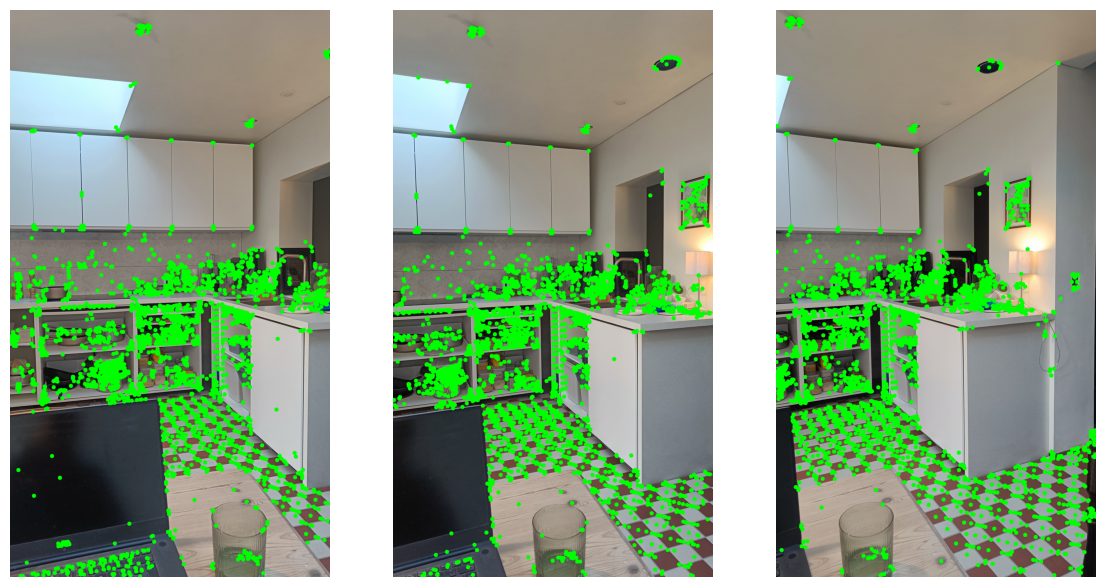

In [7]:
# display the keypoints

sift_img_1 = draw_sift_features(img_1, kp_1_sift)
sift_img_2 = draw_sift_features(img_2, kp_2_sift)
sift_img_3 = draw_sift_features(img_3, kp_3_sift)


display_images([sift_img_1, sift_img_2, sift_img_3])

In [8]:
# match keypoint features

def match_features(des1, des2):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    return matches

matches_3_1 = match_features(des_3_sift, des_1_sift)



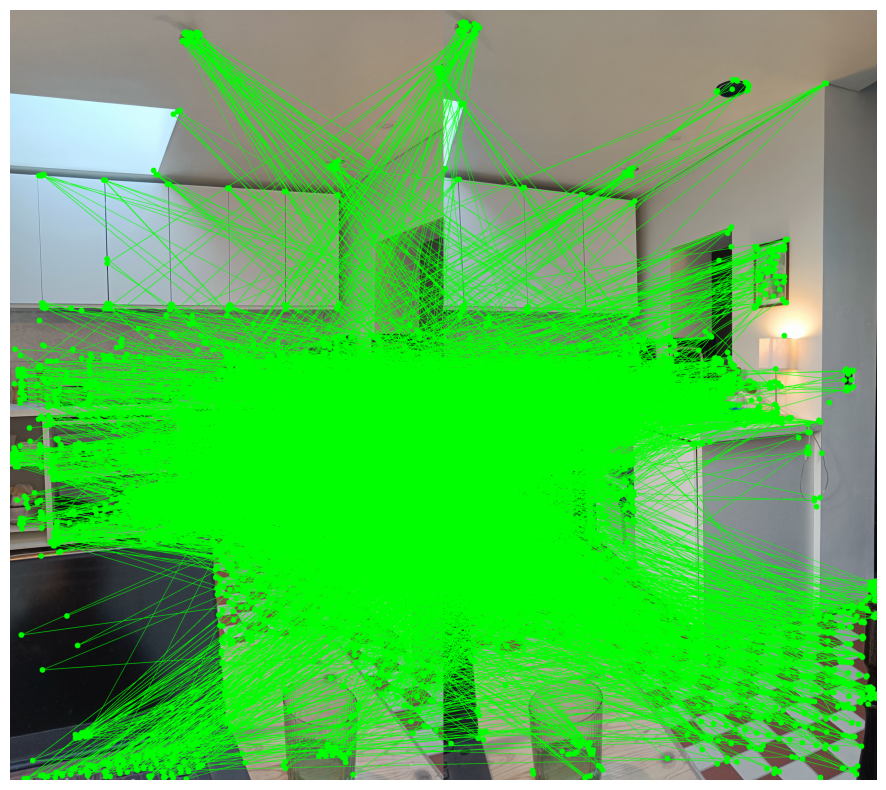

In [9]:
# display matches between two images

def draw_matches(from_img, to_img, from_kp, to_kp, matches):
    from_img = np.array(from_img)
    to_img = np.array(to_img)
    from_img = np.array(draw_sift_features(from_img, from_kp))
    to_img = np.array(draw_sift_features(to_img, to_kp))
  
    img = np.concatenate((from_img,to_img), axis=1)
    for i in range(len(matches)-1):

        from_idx = matches[i][0].queryIdx
        to_idx = matches[i][0].trainIdx
        x1, y1 = from_kp[from_idx].pt
        x2, y2 = to_kp[to_idx].pt
        x2 += from_img.shape[1]
    
        color = (0, 255, 0)
        cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
    return Image.fromarray(img)

match_img_1_3 = draw_matches(img_1, img_3, kp_1_sift, kp_3_sift, matches_3_1)

display_images([match_img_1_3])

In [10]:
# interactive display

import ipywidgets as widgets
from IPython.display import display

def display_matches_interactive(img1, img2, kp1, kp2, matches):
    def update(n_matches=10):
        match_img = draw_matches(img1, img2, kp1, kp2, sorted(matches, key=lambda x: x[0].distance)[:n_matches])
        display(match_img)
    widgets.interact(update, n_matches=(0, len(matches), 1))

display_matches_interactive(img_3, img_1, kp_3_sift, kp_1_sift, matches_3_1)

interactive(children=(IntSlider(value=10, description='n_matches', max=5000), Output()), _dom_classes=('widget…

In [11]:
matches_1_3 = sorted(matches_3_1, key=lambda x: x[0].distance)

In [12]:
# compute homography

def compute_homography(from_kp, to_kp, matches_from_to):

    # filter matches with badest distance

    src_pts = np.float32([from_kp[m[0].queryIdx].pt for m in matches_from_to]).reshape(-1, 1, 2)
    dst_pts = np.float32([to_kp[m[0].trainIdx].pt for m in matches_from_to]).reshape(-1, 1, 2)

    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    return H

H_1_3 = compute_homography(kp_3_sift, kp_1_sift, matches_3_1)

In [13]:
# manually select a point in the right image and see where it ends in the left image

def visualize_homography_matching(img1,img2,H_1_2, x2,y2):
    p1 = np.dot(H_1_2,np.array([x2,y2,1]))
    x1 = p1[0]/p1[2]
    y1 = p1[1]/p1[2]
    print(x1,y1)
    
    
    img1 = np.array(img1)
    img2 = np.array(img2)
    img1 = cv2.circle(img1,(int(x1),int(y1)),15,(0,255,0),-1)
    img2 = cv2.circle(img2,(int(x2),int(y2)),15,(0,255,0),-1)

    display_images([Image.fromarray(img1),Image.fromarray(img2)])


# create interactive visualization

def update(x=100,y=100):
    visualize_homography_matching(img_1,img_3,H_1_3,x,y)

widgets.interact(update,x=(0,1000,1),y=(0,img_1.size[1],1))

interactive(children=(IntSlider(value=100, description='x', max=1000), IntSlider(value=100, description='y', m…

<function __main__.update(x=100, y=100)>

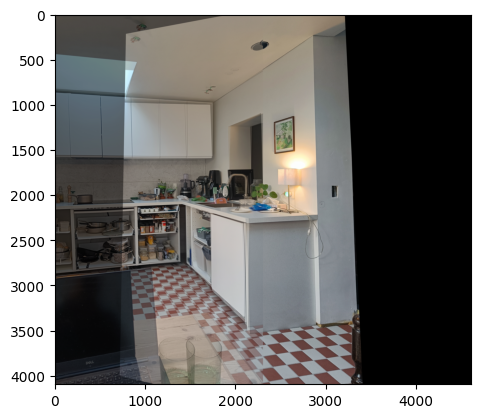

In [14]:


# stitch images

def stitch_images(left_img, right_img, H_left_right):
    left_img = np.array(left_img)
    right_img = np.array(right_img)
    warped_right_img = cv2.warpPerspective(right_img, H_left_right, (left_img.shape[1] + right_img.shape[1], left_img.shape[0]))
    # warped_right_img[:left_img.shape[0], :left_img.shape[1]] = left_img

    # blend the images 
    # if warped is black, use the right image 
    # else, use the average of the two images


    warped_right_img[0:left_img.shape[0], 0:left_img.shape[1]] = warped_right_img[0:left_img.shape[0], 0:left_img.shape[1]]/2 + left_img/2


    # plot boundary of the left image
    #cv2.polylines(warped_right_img, [np.int32([[[0,0],[0,left_img.shape[0]],[left_img.shape[1],left_img.shape[0]],[left_img.shape[1],0]]])], True, 255, 3, cv2.LINE_AA)

    plt.imshow(warped_right_img)
    #plt.imshow(right_img)
stitch_images(img_1, img_3, H_1_3)

the homography is more accurate around the center than in the edges of the image apparently. 
Maybe this is because the camera motion is not a pure rotation, but also a translation.

## OpenCV built in stitching

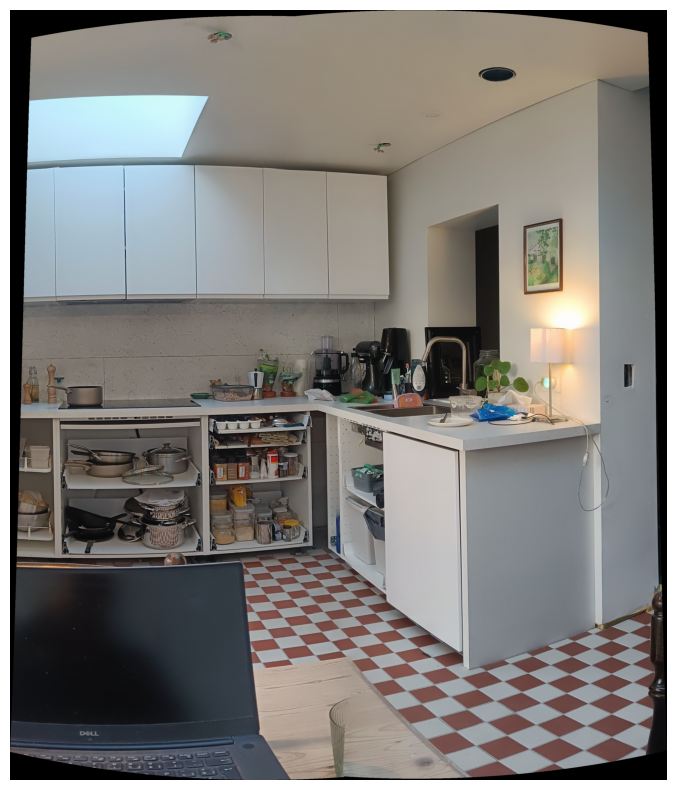

In [15]:
stitcher = cv2.Stitcher.create(mode=cv2.Stitcher_PANORAMA)

result = stitcher.stitch([np.array(img_1), np.array(img_3)])
result = Image.fromarray(result[1])

#display_images([img_1, img_3])
display_images([result])


has warped both images somehow?

seems better, but the glass at the bottom is gone so not perfect either.